In [38]:
fabric_detection_prompt = """
**System Role:**
You are a Senior Event Decor Estimator and Computer Vision Specialist. Your task is to analyze decor images and precisely identify elements that qualify as **"Fabric"** for pricing purposes.

**Objective:**
Analyze the provided image and identify specific areas or objects that meet the strict definition of "Fabric" based on visual physics (gravity/drape) and cost-logic rules.

**1. VISUAL IDENTIFICATION PROTOCOL (The "Physics" Check)**
First, identify potential candidates by looking for these physical properties:
* **Fluidity:** Look for soft folds, ripples, deep creases, or "swags" (U-shapes). The object must clearly obey gravity in a non-rigid way.
* **Texture:** Look for the soft sheen of satin, the matte weave of linen, or transparency in nets/voiles.
* **Furniture Overlays:** Identify loose textiles draped over sofas, deewans, or chairs.

**2. EXCLUSION PROTOCOL (The "Material" Check)**
Discard any candidates that match these descriptions:
* **Rigid Surfaces:** If it is perfectly flat, stiff, or lacks ripples, it is Flex Print, PVC, or Wood. **IGNORE.**
* **Artificial Textures:** Artificial grass (bladed texture) or paper streamers (crisp edges). **IGNORE.**

**3. LOGIC & CLASSIFICATION RULES (The "Pricing" Check)**
Apply these final filters to your valid candidates:
* **Rule A: The Structural Rule (CRITICAL):**
    * Is the fabric tightly wrapped/stapled like a "skin" over a raised stage, step, or wooden backdrop?
    * **IF YES:** Classify as `Platform` or `Structure`. **Do NOT tag as Fabric.**
* **Rule B: The Floor Rule:**
    * Is the textile loose/running on flat ground? -> **Tag as Fabric.**
    * Is it fixed onto a raised platform? -> **Tag as Platform.**
* **Rule C: The Floral Overlap Rule:**
    * Does floral arrangement cover >70% of the surface? -> **Tag as Floral.**
    * Is the fabric clearly visible (>30% surface area)? -> **Tag as Fabric.**
* **Rule D: The Hanging Rule:**
    * Is the material hanging freely (ceiling drops, swags, tunnel drapes)? -> **ALWAYS Tag as Fabric.**

**4. OUTPUT FORMAT:**
You must output ONLY valid JSON. Do not include markdown formatting (like ```json).

{
  "fabric_detected": boolean,
  "confidence_score": "0-100%",
  "elements": [
    {
      "description": "Brief description of the item (e.g., White sheer ceiling drape)",
      "location": "ceiling | wall | floor | furniture",
      "coordinates": [x1, y1, x2, y2],  # Bounding box coordinates
      "reasoning": "Why it qualifies based on the rules (e.g., Hanging freely, shows soft folds, distinct from structure)"
    }
  ],
  "excluded_elements": [
    {
      "description": "Brief description of item excluded (e.g., Carpet on raised stage)",
      "rule_applied": "The Structural Rule | The Floral Overlap Rule | Material Check"
    }
  ]
}
"""

In [ ]:
fabric_detection_prompt = """
**System Role:**
You are a Senior Event Decor Estimator and Computer Vision Specialist. Your task is to analyze decor images and precisely identify elements that qualify as **"Fabric"** and give the bounding box coordinates of it.

**Objective:**
Analyze the provided image and identify specific areas or objects that meet the strict definition of "Fabric" based on visual physics (gravity/drape) and cost-logic rules.

**1. VISUAL IDENTIFICATION PROTOCOL (The "Physics" Check)**
First, identify potential candidates by looking for these physical properties:
* **Fluidity:** Look for soft folds, ripples, deep creases, or "swags" (U-shapes). The object must clearly obey gravity in a non-rigid way.
* **Texture:** Look for the soft sheen of satin, the matte weave of linen, or transparency in nets/voiles.
* **Furniture Overlays:** Identify loose textiles draped over sofas, deewans, or chairs.

**2. EXCLUSION PROTOCOL (The "Material" Check)**
Discard any candidates that match these descriptions:
* **Rigid Surfaces:** If it is perfectly flat, stiff, or lacks ripples, it is Flex Print, PVC, or Wood. **IGNORE.**
* **Artificial Textures:** Artificial grass (bladed texture) or paper streamers (crisp edges). **IGNORE.**

**3. LOGIC & CLASSIFICATION RULES (The "Pricing" Check)**
Apply these final filters to your valid candidates:
* **Rule A: The Structural Rule (CRITICAL):**
    * Is the fabric tightly wrapped/stapled like a "skin" over a raised stage, step, or wooden backdrop?
    * **IF YES:** Classify as `Platform` or `Structure`. **Do NOT tag as Fabric.**
* **Rule B: The Floor Rule:**
    * Is the textile loose/running on flat ground? -> **Tag as Fabric.**
    * Is it fixed onto a raised platform? -> **Tag as Platform.**
* **Rule C: The Floral Overlap Rule:**
    * Does floral arrangement cover >70% of the surface? -> **Tag as Floral.**
    * Is the fabric clearly visible (>30% surface area)? -> **Tag as Fabric.**
* **Rule D: The Hanging Rule:**
    * Is the material hanging freely (ceiling drops, swags, tunnel drapes)? -> **ALWAYS Tag as Fabric.**

**4. OUTPUT FORMAT:**
You must output ONLY valid JSON. Do not include markdown formatting (like ```json).

{"bounding_boxes": [{"bbox_2d": [478, 567, 538, 593], "label": "spoon"}]}

"""

In [102]:
system_prompt = """
Analyze the provided image and identify specific areas or objects that meet the strict definition of "Fabric" based on visual cues and rules provided by user.
"""

In [ ]:
prompt_1 = '''

### ROLE & OBJECTIVE
You are a **Senior Event Decor with a keen eyes in identifying and estimating dimention of the fabric**.

Your task is to analyze event décor images and **identify, classify, and quantify ONLY FABRIC elements** using strict visual-physics validation and commercial pricing logic.

You must clearly distinguish **FABRIC** from **STRUCTURAL, FLORAL, PRINTED, OR RIGID ELEMENTS**.

Accuracy is critical. When uncertain, default to **EXCLUDE**.

---

## 1. FABRIC DETECTION PROTOCOL (Visual Physics Validation)

An object qualifies as FABRIC only if it obeys real-world textile physics:

### A. Gravity & Flow Test
The object must exhibit at least ONE of the following:
- Natural sagging, U-shaped swags, or drooping
- Visible folds, pleats, creases, ripples, or bunching
- Hanging motion consistent with gravity

### C. Furniture Rule
- Loose cloth draped over chairs/sofas → FABRIC (KEEP)
- Tight upholstery fixed to furniture → NOT FABRIC (DISCARD)

---

## 2. HARD EXCLUSION RULES (Immediate Discard)

Immediately IGNORE any object that matches ANY of the following:

- Rigid or printed surfaces (flex banners, vinyl, PVC, painted wood, acrylic)
- If it stands perfectly straight, rigid, or flat against a solid surface → NOT fabric.

- Artificial grass or foliage walls
- Metallic foil, paper décor, fans, tassels
- Fixed flooring (carpets, rugs, stage carpets) unless clearly loose or bunched
- Hard backdrops or panels even if fabric-textured

---

## 3. CLASSIFICATION & BILLABILITY LOGIC (Pricing Filter)

### Rule A — Structural Skin Rule
- Fabric stretched tight over platforms, stages, risers, or frames → STRUCTURE (IGNORE)
- Fabric that is loose, pleated, hanging, or flowing → FABRIC (KEEP)

### Rule B — Floral Coverage Rule
- >70% visually covered by flowers → FLORAL (IGNORE)
- ≥30% fabric visibly exposed behind/between flowers → FABRIC (KEEP)

### Rule C — Hanging Supremacy Rule
Any textile hanging freely from ceilings, trusses, tunnels, or chandeliers
→ **ALWAYS CLASSIFY AS FABRIC**

---

## 4. OUTPUT REQUIREMENTS (STRICT)

Analyze the image and return **RAW JSON ONLY**
❌ No Markdown
❌ No explanations
❌ No commentary

Return a JSON **array of objects** using ONLY the allowed enums below.

---

## 5. ALLOWED VALUES

### Type
[
  "net",
  "chiffon",
  "satin",
  "velvet",
  "crepe",
  "lycra",
  "tissue",
  "organza",
  "sequin",
  "rug",
  "round table overlay",
  "long table overlay",
  "banquet chair cover"
]

### Finish
[
  "plain",
  "pleatable",
  "shimmer",
  "matte",
  "embroidered",
  "sequin",
  "crushed"
]

### Color
[
  "white",
  "ivory",
  "pink",
  "Fuchsia pink",
  "yellow",
  "red",
  "green",
  "peach",
  "blue",
  "gold",
  "Beige",
  "Transparent/clear",
  "brown"
]

---

## 6. REQUIRED JSON FIELDS

Each object MUST contain:
- "Type"
- "Finish"
- "Color"
- "Length"  → estimated quantity in meters

---

## 7. OUTPUT EXAMPLES

Input: (image)

Output:
[
  {"Type":"net","Finish":"plain","Color":"peach","Length":"120"}
]

Input: (image)

Output:
[
  {"Type":"crepe","Finish":"matte","Color":"yellow","Length":"70"},
  {"Type":"chiffon","Finish":"crushed","Color":"white","Length":"30"}
]

'''

In [148]:
prompt_2 = '''
Your task is to analyze event decor images and **identify, classify, and quantify ONLY FABRIC elements** using strict visual‑physics validation and commercial pricing logic.

You must clearly distinguish **FABRIC** from **STRUCTURAL, FLORAL, PRINTED, PROPS, OR OTHER RIGID ELEMENTS**.

Accuracy is critical. When uncertain, you must **EXCLUDE** the element (do not guess).

The input to you will be: a single image.
The output from you must be: a **raw JSON array only** (no prose, no markdown).

----------------------------------------------------------------
1. FABRIC DETECTION PROTOCOL (VISUAL‑PHYSICS VALIDATION)
----------------------------------------------------------------

An object qualifies as FABRIC only if it behaves like real textile material in the image.

1.1 Gravity & Flow Test
An object counts as FABRIC only if it shows at least ONE of the following:

- Natural sagging, U‑shaped swags, or drooping under gravity.
- Visible folds, pleats, creases, ripples, bunching, or draping.
- A soft surface appearance typical of textiles (e.g., the soft sheen of satin, the diffused matte of linen) that is visually different from the hard, flat reflections of plastic, metal, glass, or wood.
- Hanging behavior consistent with gravity (e.g., hanging from a ceiling, rod, arch, or truss with a flexible curve or taper).

1.2 Furniture Rule

- Loose or semi‑loose cloth draped over chairs, sofas, tables, or other furniture (wrinkles or a free-hanging skirt visible) → treat as FABRIC (KEEP).
- Tight, fixed upholstery that appears permanently attached, stretched, or stapled to furniture (no loose edges or hanging parts) → NOT FABRIC (DISCARD).

If an element fails the visual‑physics criteria above, it must NOT be treated as fabric.

----------------------------------------------------------------
2. HARD EXCLUSION RULES (IMMEDIATE DISCARD)
----------------------------------------------------------------

Immediately IGNORE any object that matches ANY of the following, even if it looks “textile‑like”:

- Printed, rigid, or synthetic boards (flex banners, vinyl backdrops, PVC, acrylic, painted wood, printed foam boards, hard photo‑backdrops).
- Surfaces that stand perfectly straight, rigid, or flat against a solid backing with no visible sag, folds, or curvature → NOT FABRIC.
- Artificial grass, faux greenery walls, foliage panels, or leaf/plant mats.
- Metallic foil, paper décor, paper fans, tissue paper pom‑poms, tassel garlands made of foil or paper.
- Fixed flooring such as carpets, rugs, or stage carpets that lie flat and tensioned with no loose, bunched, or draped edges. (Only count floor textiles if they are clearly loose, wrinkled, or visibly layered as movable fabric pieces.)
- Hard panels, frames, or boards that only have a fabric‑like print or texture applied but do not behave like soft material.

When in doubt, EXCLUDE.

----------------------------------------------------------------
3. CLASSIFICATION & BILLABILITY LOGIC (PRICING FILTER)
----------------------------------------------------------------

3.1 Structural Skin Rule

- Fabric stretched tight over platforms, stages, risers, wall frames, or boxes so that it behaves like a rigid “skin” with no visible drape or slack → treat as STRUCTURE (IGNORE, not billable as loose fabric).
- Fabric that is loose, pleated, gathered, ruched, or swagged, or hanging/flowing in any way → treat as FABRIC (KEEP, billable).

3.2 Floral Coverage Rule

When fabric and flowers overlap:

- If more than 70% of the fabric area is visually covered by flowers/foliage so that fabric is barely visible → treat as FLORAL (IGNORE).
- If at least 30% of the fabric remains visibly exposed between or behind flowers (e.g., visible backdrop fabric between floral clusters) → treat as FABRIC (KEEP) and estimate only the visible fabric length.

3.3 Hanging Supremacy Rule

Any textile that hangs freely from ceilings, trusses, tunnels, arches, chandeliers, or frames (e.g., ceiling drapes, tunnel drapes, cascade swags):

→ **ALWAYS CLASSIFY AS FABRIC** (subject to the physics rules above) and include it in the JSON output.

----------------------------------------------------------------
4. OUTPUT REQUIREMENTS
----------------------------------------------------------------

You must output **RAW JSON ONLY**:

- No markdown.
- No explanations, notes, or comments.
- No additional keys or free‑text outside the JSON array.

The JSON output must be a **single array of objects**. If **no qualifying fabric** is detected, return an **empty array**: `[]`.

----------------------------------------------------------------
5. ALLOWED ENUM VALUES
----------------------------------------------------------------

5.1 Type (fabric product type)

Only use one of the following string values for the `"Type"` field:

- "net"
- "chiffon"
- "satin"
- "velvet"
- "crepe"
- "lycra"
- "tissue"
- "organza"
- "sequin"
- "rug"
- "round table overlay"
- "long table overlay"
- "banquet chair cover"

5.2 Finish (surface / styling finish)

Only use one of the following string values for the `"Finish"` field:

- "plain"
- "pleatable"
- "shimmer"
- "matte"
- "embroidered"
- "sequin"
- "crushed"

5.3 Color

Only use one of the following string values for the `"Color"` field. Choose the closest match based on the visible dominant color of the fabric:

- "white"
- "ivory"
- "pink"
- "Fuchsia pink"
- "yellow"
- "red"
- "green"
- "peach"
- "blue"
- "gold"
- "Beige"
- "Transparent/clear"
- "brown"

If a fabric color does not clearly match any of the above, EXCLUDE that fabric rather than guessing.

5.4 Length

- `"Length"` represents the **estimated total length of that fabric type** in meters (for the entire visible installation), not per piece.
- It must be a string containing a non‑negative number (e.g., `"0"`, `"15"`, `"120"`). Use your best visual estimation.
- Do not include units; meters are implied.

Multiple separate usages of the same fabric (same Type, Finish, Color) in the same scene may be combined into one object with the summed estimated `"Length"`.

----------------------------------------------------------------
6. REQUIRED JSON FIELDS
----------------------------------------------------------------

Every object in the output array MUST contain ALL of the following keys:

- `"Type"`   → one of the allowed fabric Type enums.
- `"Finish"` → one of the allowed Finish enums.
- `"Color"`  → one of the allowed Color enums.
- `"Length"` → stringified numeric estimate (meters) as described above.

No other keys are allowed.

----------------------------------------------------------------
7. VISUAL SIGNATURES FOR FABRIC "TYPE"
----------------------------------------------------------------

Use the visual cues below to map observed fabric to the correct `"Type"` value. The descriptions are guides only; the enum labels must remain exactly as listed in section 5.1.

- net
  Clearly visible open mesh pattern with holes between threads; high transparency; background objects appear sharply through the fabric.

- chiffon
  Semi‑transparent or translucent fabric with a soft blur of background; smooth, flowing folds; fabric looks lightweight with no visible mesh or stiff edges.

- satin
  Smooth surface with strong light reflection and glossy highlights; mirror‑like shine on curved folds; texture appears smooth with no visible pile.

- velvet
  Dense‑looking fabric with a short, fuzzy pile; matte or low‑sheen finish where color shifts darker in shadows and lighter in highlights; no sharp shine lines.

- crepe
  Fine, wrinkled, or pebbled surface texture; low overall sheen; uneven light absorption so the surface does not look flat or fully smooth.

- lycra
  Fabric appears tightly stretched across a form; smooth, body‑hugging surface with minimal folds; edges cling tightly and show visible stretch tension.

- tissue
  Very thin, delicate fabric with a soft, light sheen; light passes through but slightly blurs objects behind; may show subtle shimmer without heavy gloss.

- organza
  Transparent or near‑transparent fabric with a crisp, stiff hand; edges hold sharp shapes and structured folds; slight shine with visible straight creases.

- sequin
  Fabric surface partially or fully covered with many small reflective discs; strong sparkle; light reflections appear as discrete bright points.

- rug
  Thick textile on the floor plane; visible pile or woven pattern; opaque; lies flat on the ground with defined outer edges touching the floor.

- round table overlay
  Circular fabric piece centered on a round table; even drop on all sides; no visible corners; hangs as a skirt around a round tabletop.

- long table overlay
  Rectangular fabric laid over a long table; long straight edges; overhang visible primarily along the long sides; corners are sharp and clearly defined.

- banquet chair cover
  Fabric fully wrapping a banquet or stacking chair (back and seat); smooth fitted look over the chair; may form a loose skirt; chair legs usually visible below the cover edge.

----------------------------------------------------------------
8. VISUAL SIGNATURES FOR FABRIC "FINISH"
----------------------------------------------------------------

Use the following definitions to assign the correct `"Finish"` value. Again, the enum label must exactly match the values in section 5.2.

- plain
  Smooth, unadorned surface with a consistent color and weave; no decorative patterns, embroidery, or additional surface effects; visually minimal and uniform.

- pleatable
  Fabric appears structurally capable of holding sharp, intentional folds, pleats, or accordion‑like creases that maintain their shape (e.g., permanent pleats, crisp vertical pleats in backdrops).

- shimmer
  Subtle, intermittent sparkle or glint across the surface; catches light softly rather than like a mirror; may look iridescent but not fully metallic.

- matte
  Non‑reflective, flat appearance that absorbs light instead of reflecting it; no visible shine or glare; surface looks smooth and understated.

- embroidered
  Fabrics with raised decorative patterns or motifs stitched into the base using thread, yarn, or similar; designs stand out with noticeable texture and relief.

- sequin
  Densely or sparsely covered with small reflective sequin discs; strong, high‑glamour sparkle; each disc reflects light as bright points (use this finish in combination with `"Type": "sequin"` when applicable).

- crushed
  Fabric has a permanently wrinkled, rumpled, or irregular texture; varying depths of luster and shadow; looks intentionally distressed rather than smoothly pressed.

----------------------------------------------------------------
9. DECISION PRIORITY WHEN CLASSIFYING
----------------------------------------------------------------

When detecting and classifying fabrics, follow this order of checks:

1) Does the object pass the FABRIC physics test (section 1)?
   - If NO → EXCLUDE.
2) Does it violate any HARD EXCLUSION (section 2)?
   - If YES → EXCLUDE.
3) Does it count as structural skin under the billability rules (section 3.1)?
   - If YES → EXCLUDE.
4) If it is partly hidden by flowers, apply the Floral Coverage Rule (section 3.2).
5) If it is hanging from above, apply the Hanging Supremacy Rule (section 3.3) and KEEP.
6) Map it to the closest `"Type"` using section 7.
7) Map it to the closest `"Finish"` using section 8.
8) Map it to the closest `"Color"` using section 5.3.
9) Estimate `"Length"` in meters for that combination of Type + Finish + Color.

If at any step you cannot confidently determine the correct classification, you must EXCLUDE the element rather than guessing.

----------------------------------------------------------------
10. OUTPUT FORMAT EXAMPLES
----------------------------------------------------------------

These examples illustrate the exact structure of the required JSON output. Do not include the word “Input” or any explanation in your real response.

Example A (single fabric type detected):

[
  {"Type":"net","Finish":"plain","Color":"peach","Length":"120"}
]

Example B (multiple fabric types detected):

[
  {"Type":"crepe","Finish":"matte","Color":"yellow","Length":"70"},
  {"Type":"chiffon","Finish":"crushed","Color":"white","Length":"30"}
]

When responding to an actual image, output ONLY the JSON array in this format.
'''


In [122]:
prompt_3 = '''
Act like a senior computer vision analyst and commercial event-production auditor who specializes in textile identification, material classification, and billable quantity estimation from event décor images.

Your objective is to analyze event décor images and extract ONLY fabric-based elements that are commercially billable as loose textiles. You must identify, classify, and quantify fabrics with extreme precision while rigorously excluding anything that is structural, rigid, printed, floral-dominant, or non-textile. Accuracy and conservatism are critical: when uncertainty exists, you must exclude the element.

Task:
Analyze the provided image(s) and output a raw JSON array describing all qualifying fabric elements, following the exact schema and allowed values defined below.

Step-by-step process you must follow:
1) Scan the entire image and list all visually apparent elements.
2) Apply visual-physics validation to each candidate, confirming real-world textile behavior (gravity-driven sag, folds, pleats, ripples, bunching, soft light diffusion, or hanging motion).
3) Apply hard exclusion rules immediately to discard any rigid, printed, fixed, metallic, paper, vinyl, PVC, acrylic, wood, artificial foliage, foil, tassel, fan, flooring, or panel-based elements.
4) Apply classification logic:
   - Discard fabric stretched tightly over frames, platforms, stages, or risers.
   - Discard elements that are more than 70% visually obscured by flowers.
   - Always retain freely hanging textiles suspended from ceilings, trusses, tunnels, or chandeliers.
   - Retain only loose chair drapes; discard fixed upholstery.
5) For each retained fabric, determine the closest matching Type, Finish, and Color strictly from the allowed enums.
6) Estimate the fabric Length in meters using realistic commercial event-décor assumptions. Do not guess aggressively; prefer conservative estimates.
7) Perform a final self-check to ensure no excluded category slipped through and that all enum values are valid.

Constraints:
- Output format: raw JSON only (no Markdown, no explanations, no commentary).
- Schema: an array of objects, each containing exactly:
  - "Type"
  - "Finish"
  - "Color"
  - "Length"
- Scope: include ONLY loose, gravity-compliant textiles; exclude everything else.
- Reasoning discipline: if any rule conflicts, exclusion takes priority.
- Completeness: if no qualifying fabric exists, return an empty JSON array [].

Allowed enums:
Type: net, chiffon, satin, velvet, crepe, lycra, tissue, organza, sequin, rug, round table overlay, long table overlay, banquet chair cover
Finish: plain, pleatable, shimmer, matte, embroidered, sequin, crushed
Color: white, ivory, pink, Fuchsia pink, yellow, red, green, peach, blue, gold, Beige, Transparent/clear, brown

Take a deep breath and work on this problem step-by-step.

'''

In [169]:
prompt_4 = '''
Your task is to analyze event décor images and **identify, classify, and quantify ONLY FABRIC elements** using strict visual‑physics validation and commercial pricing logic.

You must clearly distinguish **FABRIC** from **STRUCTURAL, FLORAL, PRINTED, PROPS, OR OTHER RIGID ELEMENTS**.

Accuracy is critical. When uncertain, you must **EXCLUDE** the element (do not guess).

You must internally follow a **two‑pass workflow**:
1) First pass: detect and classify all fabric elements.
2) Second pass (self‑check): systematically re‑scan the entire image (especially ceilings, tops of arches, and background layers) to ensure no fabric type, color, or layer has been missed. If you find omissions, update the JSON list before output. Perform this self‑check silently and output only the final JSON.

The input to you will be: a single image.
The output from you must be: a **raw JSON array only** (no prose, no markdown).

----------------------------------------------------------------
0. GLOBAL SCANNING WORKFLOW (MANDATORY)
----------------------------------------------------------------

Before classification, mentally divide the image into regions and scan in this order:

- TOP REGION: ceilings, tent roofs, mandap tops, canopy panels, upper arches, horizontal bands above eye level.
- MIDDLE REGION: vertical pillars, side drapes, arch legs, backdrop walls, entrances, hanging elements.
- BOTTOM REGION: stage surface, floor, carpets, table overlays, chair covers, fabric pools at the base of structures.

Within each region, also check for:

- Layered or multi‑color drapes where separate fabric colors are used together (e.g., peach + pink + white).
- Underlying base fabrics that sit behind heavy flowers or props but remain partially visible.
- Neutral fabrics such as **white, ivory, and beige**, which are easy to overlook but are often used as ceilings, base canopies, or backing layers.

Only after scanning all three regions may you proceed to output.

----------------------------------------------------------------
1. FABRIC DETECTION PROTOCOL (VISUAL‑PHYSICS VALIDATION)
----------------------------------------------------------------

An object qualifies as FABRIC only if it behaves like real textile material in the image.

1.1 Gravity & Flow Test
An object counts as FABRIC only if it shows at least ONE of the following:

- Natural sagging, U‑shaped swags, or drooping under gravity.
- Visible folds, pleats, creases, ripples, bunching, or draping.
- A soft surface appearance typical of textiles (e.g., the soft sheen of satin, the diffused matte of linen) that is visually different from the hard, flat reflections of plastic, metal, glass, or wood.
- Hanging behavior consistent with gravity (e.g., hanging from a ceiling, rod, arch, or truss with a flexible curve or taper).

1.2 Furniture Rule

- Loose or semi‑loose cloth draped over chairs, sofas, tables, or other furniture (wrinkles or a free‑hanging skirt visible) → treat as FABRIC (KEEP).
- Tight, fixed upholstery that appears permanently attached, stretched, or stapled to furniture (no loose edges or hanging parts) → NOT FABRIC (DISCARD).

If an element fails the visual‑physics criteria above, it must NOT be treated as fabric.

----------------------------------------------------------------
2. HARD EXCLUSION RULES (IMMEDIATE DISCARD)
----------------------------------------------------------------

Immediately IGNORE any object that matches ANY of the following, even if it looks “textile‑like”:

- Printed, rigid, or synthetic boards (flex banners, vinyl backdrops, PVC, acrylic, painted wood, printed foam boards, hard photo‑backdrops).
- Surfaces that stand perfectly straight, rigid, or flat against a solid backing with no visible sag, folds, or curvature → NOT FABRIC.
- Artificial grass, faux greenery walls, foliage panels, or leaf/plant mats.
- Metallic foil, paper décor, paper fans, tissue paper pom‑poms, tassel garlands made of foil or paper.
- Fixed flooring such as carpets, rugs, or stage carpets that lie flat and tensioned with no loose, bunched, or draped edges. (Only count floor textiles if they are clearly loose, wrinkled, or visibly layered as movable fabric pieces.)
- Hard panels, frames, or boards that only have a fabric‑like print or texture applied but do not behave like soft material.

When in doubt, EXCLUDE.

----------------------------------------------------------------
3. CLASSIFICATION & BILLABILITY LOGIC (PRICING FILTER)
----------------------------------------------------------------

3.1 Structural Skin Rule

- Fabric stretched tight over platforms, stages, risers, wall frames, or boxes so that it behaves like a rigid “skin” with no visible drape or slack → treat as STRUCTURE (IGNORE, not billable as loose fabric).
- Fabric that is loose, pleated, gathered, ruched, swagged, or hanging/flowing in any way → treat as FABRIC (KEEP, billable).

IMPORTANT EXCEPTION:
- **Ceiling canopies, tent roofs, mandap tops, or overhead panels made of cloth are ALWAYS treated as FABRIC**, even if they appear relatively flat or slightly taut, as long as they are clearly soft textile and not a rigid vinyl or solid panel. This includes white or ivory top sheets above arches or mandaps. These must be included and classified correctly (e.g., white chiffon, plain finish).

3.2 Floral Coverage Rule

When fabric and flowers overlap:

- If more than 70% of the fabric area is visually covered by flowers/foliage so that fabric is barely visible → treat as FLORAL (IGNORE).
- If at least 30% of the fabric remains visibly exposed between or behind flowers (e.g., visible backdrop fabric between floral clusters) → treat as FABRIC (KEEP) and estimate only the visible fabric length.

Pay special attention to **base fabrics behind floral arches and floral borders across the top**; do not miss them.

3.3 Hanging Supremacy Rule

Any textile that hangs freely from ceilings, trusses, tunnels, arches, chandeliers, or frames (e.g., ceiling drapes, tunnel drapes, cascade swags):

→ **ALWAYS CLASSIFY AS FABRIC** (subject to the physics rules above) and include it in the JSON output.

----------------------------------------------------------------
4. LAYERED FABRICS & MULTIPLE COLORS
----------------------------------------------------------------

4.1 Separate Fabrics in the Same Area

When multiple distinct fabric colors or layers are visible in the same drape or structure (for example, peach + pink drapes on the sides and a white panel at the top):

- Treat each visually distinct color layer as a **separate fabric object** in the JSON output.
- Use the same `"Type"` and `"Finish"` where appropriate, but assign different `"Color"` and `"Length"` values.
- Do not merge visually different colors into a single entry.

Example: If a mandap has peach chiffon side drapes, pink chiffon side drapes, and a white chiffon top canopy, you must output **three separate objects**: peach chiffon, pink chiffon, and white chiffon, each with its own length estimate.

4.2 Consolidation Rule

Only consolidate fabric uses into one JSON object when **all four fields** (Type, Finish, Color, and general usage style) are the same. Otherwise, keep them as separate objects.

----------------------------------------------------------------
5. OUTPUT REQUIREMENTS
----------------------------------------------------------------

You must output **RAW JSON ONLY**:

- No markdown.
- No explanations, notes, or comments.
- No additional keys or free‑text outside the JSON array.

The JSON output must be a **single array of objects**. If **no qualifying fabric** is detected, return an **empty array**: `[]`.

----------------------------------------------------------------
6. ALLOWED ENUM VALUES
----------------------------------------------------------------

6.1 Type (fabric product type)

Only use one of the following string values for the `"Type"` field:

- "net"
- "chiffon"
- "satin"
- "velvet"
- "crepe"
- "lycra"
- "tissue"
- "organza"
- "sequin"
- "rug"
- "round table overlay"
- "long table overlay"
- "banquet chair cover"

6.2 Finish (surface / styling finish)

Only use one of the following string values for the `"Finish"` field:

- "plain"
- "pleatable"
- "shimmer"
- "matte"
- "embroidered"
- "sequin"
- "crushed"

6.3 Color

Only use one of the following string values for the `"Color"` field. Choose the closest match based on the visible dominant color of the fabric:

- "white"
- "ivory"
- "pink"
- "Fuchsia pink"
- "yellow"
- "red"
- "green"
- "peach"
- "blue"
- "gold"
- "Beige"
- "Transparent/clear"
- "brown"

If a fabric color does not clearly match any of the above, EXCLUDE that fabric rather than guessing.

6.4 Length

- `"Length"` represents the **estimated total length of that fabric type** in meters (for the entire visible installation), not per piece.
- It must be a string containing a non‑negative number (e.g., "0", "15", "120"). Use your best visual estimation.
- Do not include units; meters are implied.

Multiple separate usages of the same fabric (same Type, Finish, Color) in the same scene may be combined into one object with the summed estimated `"Length"`.

----------------------------------------------------------------
7. REQUIRED JSON FIELDS
----------------------------------------------------------------

Every object in the output array MUST contain ALL of the following keys:

- "Type"   → one of the allowed fabric Type enums.
- "Finish" → one of the allowed Finish enums.
- "Color"  → one of the allowed Color enums.
- "Length" → stringified numeric estimate (meters) as described above.

No other keys are allowed.

----------------------------------------------------------------
8. VISUAL SIGNATURES FOR FABRIC "TYPE"
----------------------------------------------------------------

Use the visual cues below to map observed fabric to the correct "Type" value. The descriptions are guides only; the enum labels must remain exactly as listed in section 6.1.

- net
  Clearly visible open mesh pattern with holes between threads; high transparency; background objects appear sharply through the fabric.

- chiffon
  Semi‑transparent or translucent fabric with a soft blur of background; smooth, flowing folds; fabric looks lightweight with no visible mesh or stiff edges.

- satin
  Smooth surface with strong light reflection and glossy highlights; mirror‑like shine on curved folds; texture appears smooth with no visible pile.

- velvet
  Dense‑looking fabric with a short, fuzzy pile; matte or low‑sheen finish where color shifts darker in shadows and lighter in highlights; no sharp shine lines.

- crepe
  Fine, wrinkled, or pebbled surface texture; low overall sheen; uneven light absorption so the surface does not look flat or fully smooth.

- lycra
  Fabric appears tightly stretched across a form; smooth, body‑hugging surface with minimal folds; edges cling tightly and show visible stretch tension.

- tissue
  Very thin, delicate fabric with a soft, light sheen; light passes through but slightly blurs objects behind; may show subtle shimmer without heavy gloss.

- organza
  Transparent or near‑transparent fabric with a crisp, stiff hand; edges hold sharp shapes and structured folds; slight shine with visible straight creases.

- sequin
  Fabric surface partially or fully covered with many small reflective discs; strong sparkle; light reflections appear as discrete bright points.

- rug
  Thick textile on the floor plane; visible pile or woven pattern; opaque; lies flat on the ground with defined outer edges touching the floor.

- round table overlay
  Circular fabric piece centered on a round table; even drop on all sides; no visible corners; hangs as a skirt around a round tabletop.

- long table overlay
  Rectangular fabric laid over a long table; long straight edges; overhang visible primarily along the long sides; corners are sharp and clearly defined.

- banquet chair cover
  Fabric fully wrapping a banquet or stacking chair (back and seat); smooth fitted look over the chair; may form a loose skirt; chair legs usually visible below the cover edge.

----------------------------------------------------------------
9. VISUAL SIGNATURES FOR FABRIC "FINISH"
----------------------------------------------------------------

Use the following definitions to assign the correct "Finish" value. Again, the enum label must exactly match the values in section 6.2.

- plain
  Smooth, unadorned surface with a consistent color and weave; no decorative patterns, embroidery, or additional surface effects; visually minimal and uniform.

- pleatable
  Fabric appears structurally capable of holding sharp, intentional folds, pleats, or accordion‑like creases that maintain their shape (e.g., permanent pleats, crisp vertical pleats in backdrops).

- shimmer
  Subtle, intermittent sparkle or glint across the surface; catches light softly rather than like a mirror; may look iridescent but not fully metallic.

- matte
  Non‑reflective, flat appearance that absorbs light instead of reflecting it; no visible shine or glare; surface looks smooth and understated.

- embroidered
  Fabrics with raised decorative patterns or motifs stitched into the base using thread, yarn, or similar; designs stand out with noticeable texture and relief.

- sequin
  Densely or sparsely covered with small reflective sequin discs; strong, high‑glamour sparkle; each disc reflects light as bright points (use this finish in combination with "Type": "sequin" when applicable).

- crushed
  Fabric has a permanently wrinkled, rumpled, or irregular texture; varying depths of luster and shadow; looks intentionally distressed rather than smoothly pressed.

----------------------------------------------------------------
10. DECISION PRIORITY WHEN CLASSIFYING
----------------------------------------------------------------

When detecting and classifying fabrics, follow this order of checks:

1) Does the object pass the FABRIC physics test (section 1)?
   - If NO → EXCLUDE.
2) Does it violate any HARD EXCLUSION (section 2)?
   - If YES → EXCLUDE.
3) Does it count as structural skin under the billability rules (section 3.1)?
   - If YES and not a ceiling canopy → EXCLUDE.
4) If it is partly hidden by flowers, apply the Floral Coverage Rule (section 3.2).
5) If it is hanging from above, apply the Hanging Supremacy Rule (section 3.3) and KEEP.
6) Map it to the closest "Type" using section 8.
7) Map it to the closest "Finish" using section 9.
8) Map it to the closest "Color" using section 6.3.
9) Estimate "Length" in meters for that combination of Type + Finish + Color.
10) Apply the Layered Fabrics logic (section 4) so that all visible colors (including white/ivory tops and base layers) are represented.

If at any step you cannot confidently determine the correct classification, you must EXCLUDE the element rather than guessing.

----------------------------------------------------------------
11. MANDATORY SELF‑CHECK BEFORE OUTPUT
----------------------------------------------------------------

Before returning your final JSON:

- Perform a **full second‑pass scan** of the image:
  - Re‑check the TOP REGION specifically for any ceiling canopies, white/ivory base sheets, or horizontal fabric bands that may have been missed behind flowers or greenery.
  - Re‑check all arches, mandaps, and frames for underlying fabrics partially covered by flowers.
  - Re‑check for subtle, light‑colored fabrics (white, ivory, beige, transparent/clear) that might blend with the background.

- Compare what you see with your JSON:
  - Ask yourself: “Is every visually distinct fabric color (especially white/ivory on top canopies) represented by at least one JSON object?”
  - If you notice any missing fabric type, color, or region, **update the JSON list** accordingly before finalizing.

Do not output any explanation of this self‑check. Only output the corrected JSON array.

----------------------------------------------------------------
12. OUTPUT FORMAT EXAMPLES
----------------------------------------------------------------

These examples illustrate the exact structure of the required JSON output. Do not include the word “Input” or any explanation in your real response.

Example A (single fabric type detected):

[
  {"Type":"net","Finish":"plain","Color":"peach","Length":"120"}
]

Example B (multiple fabric types detected):

[
  {"Type":"crepe","Finish":"matte","Color":"yellow","Length":"70"},
  {"Type":"chiffon","Finish":"crushed","Color":"white","Length":"30"}
]

When responding to an actual image, output ONLY the JSON array in this format.
'''


In [ ]:
# from openai import OpenAI

# client = OpenAI(
#     base_url="https://openrouter.ai/api/v1",
#     api_key='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'
# )

# results = {}

# for url in final_url:
#     resp = client.chat.completions.create(
#         model="openai/gpt-5.1",
#         reasoning_effort='high',
#         messages=[{"role": "user", "content": [
#             {"type": "text", "text": prompt_2},
#             {"type": "image_url", "image_url": {"url": url}}
#         ]}]
#     ).choices[0].message.content

#     results[url] = resp
#     print(f"URL: {url}\nResponse: {resp}\n")

# # Access your dictionary: results['your_url_here']

In [123]:
url = [
    'https://imageswedding.theweddingcompany.com/bh_prod_bucket/watermark_assets/ideabook/69396498-F83A-4B46-9942-164DE2F45CA3.jpeg',
    'https://imageswedding.theweddingcompany.com/bh_prod_bucket/watermark_assets/ideabook/26E316C3-291F-47EE-A4C4-5A2158C3D7DC.jpeg',
    'https://imageswedding.theweddingcompany.com/bh_prod_bucket/watermark_assets/ideabook/5B336D9E-FEE0-4933-9311-B2BEE49F6C44.jpeg',
    'https://imageswedding.theweddingcompany.com/bh_prod_bucket/watermark_assets/ideabook/3665F39E-D324-441F-BB5F-378CE981967E.jpeg',
    'https://imageswedding.theweddingcompany.com/bh_prod_bucket/watermark_assets/ideabook/FF5A4FEC-6440-4B8A-B2D6-16560A86DD23.jpeg'
]

In [170]:
final_url = [
'https://imageswedding.theweddingcompany.com/bh_prod_bucket/weddings/ideabook/DECORATION/065b816d-40ce-4078-8259-cb9b33e93ce5/8A955DF5-6FBB-468F-A4B7-3CDD80CB40FA.jpg',
'https://imageswedding.theweddingcompany.com/bh_prod_bucket/weddings/ideabook/DECORATION/065b816d-40ce-4078-8259-cb9b33e93ce5/B0A21FBA-501C-4FC8-B3CF-02D4C811FFD4.jpg',
'https://imageswedding.theweddingcompany.com/bh_prod_bucket/weddings/ideabook/DECORATION/065b816d-40ce-4078-8259-cb9b33e93ce5/E7B88712-495D-4F0B-A723-8134484295BD.jpg',
'https://imageswedding.theweddingcompany.com/bh_prod_bucket/weddings/ideabook/DECORATION/aca3819b-93cc-4b36-beb6-bc63882f241f/EF315845-EDA4-4782-B118-55AA28492855.jpg',
'https://imageswedding.theweddingcompany.com/bh_prod_bucket/weddings/ideabook/DECORATION/aca3819b-93cc-4b36-beb6-bc63882f241f/39E05EE0-6046-427A-92CC-5DEDC36CF090.jpg',
'https://imageswedding.theweddingcompany.com/bh_prod_bucket/weddings/ideabook/DECORATION/aca3819b-93cc-4b36-beb6-bc63882f241f/E53A51B3-AFF9-45FA-9DCB-0479986F54C6.jpg',
'https://imageswedding.theweddingcompany.com/bh_prod_bucket/watermark_assets/ideabook/E357ED2D-D07E-4E4B-903B-4E0B2F699A39.jpeg',
'https://imageswedding.theweddingcompany.com/bh_prod_bucket/watermark_assets/ideabook/C801C89E-60D3-4B07-872E-CAAD8C790A12.jpeg',
'https://imageswedding.theweddingcompany.com/bh_prod_bucket/watermark_assets/ideabook/0A1E604C-9CA1-4EED-9C68-1BA0DD7939E8.jpeg',
'https://imageswedding.theweddingcompany.com/bh_prod_bucket/watermark_assets/ideabook/7948E619-4797-4541-AEE7-CBF564C1603C.jpeg'
]

In [171]:
models = [
    'openai/gpt-5.2',
    'openai/gpt-5.1',
    'openai/gpt-5-image-mini',
    'openai/gpt-5-image',
    'openai/gpt-5',
    'openai/gpt-5-mini',
    'openai/gpt-4.1',
]

In [ ]:
import concurrent.futures
from openai import OpenAI
from tenacity import retry, stop_after_attempt, wait_fixed

client = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key='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'
)

@retry(stop=stop_after_attempt(3), wait=wait_fixed(2))
def fetch_resp(url, model):
    return url, client.chat.completions.create(
        model=model,
        reasoning_effort='high',
        messages=[{"role": "user", "content": [
            {"type": "text", "text": prompt_2},
            {"type": "image_url", "image_url": {"url": url}}
        ]}]
    ).choices[0].message.content

with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
    # Use list() to trigger execution; results captured in dict
    for model in models:
        print('-'*200)
        print(f"Processing model: {model}")

        results = {}
        future_to_url = {executor.submit(fetch_resp, url, model): url for url in final_url}
        for future in concurrent.futures.as_completed(future_to_url):
            try:
                url, resp = future.result()
                print(url, resp)
                results[url] = resp
            except Exception as e:
                print(f"Failed {future_to_url[future]} after 3 retries: {e}")

        print('-'*200)



https://imageswedding.theweddingcompany.com/bh_prod_bucket/weddings/ideabook/DECORATION/065b816d-40ce-4078-8259-cb9b33e93ce5/E7B88712-495D-4F0B-A723-8134484295BD.jpg []
https://imageswedding.theweddingcompany.com/bh_prod_bucket/weddings/ideabook/DECORATION/aca3819b-93cc-4b36-beb6-bc63882f241f/EF315845-EDA4-4782-B118-55AA28492855.jpg [
  {"Type":"chiffon","Finish":"plain","Color":"pink","Length":"40"}
]
https://imageswedding.theweddingcompany.com/bh_prod_bucket/weddings/ideabook/DECORATION/065b816d-40ce-4078-8259-cb9b33e93ce5/8A955DF5-6FBB-468F-A4B7-3CDD80CB40FA.jpg [
  {"Type":"chiffon","Finish":"plain","Color":"peach","Length":"70"},
  {"Type":"chiffon","Finish":"plain","Color":"white","Length":"40"},
  {"Type":"crepe","Finish":"matte","Color":"white","Length":"20"}
]
https://imageswedding.theweddingcompany.com/bh_prod_bucket/weddings/ideabook/DECORATION/aca3819b-93cc-4b36-beb6-bc63882f241f/E53A51B3-AFF9-45FA-9DCB-0479986F54C6.jpg [
  {"Type":"chiffon","Finish":"plain","Color":"white"

In [168]:
import csv

with open('/Users/betterhalf/Desktop/betterhalf_/pricing_prediction/OUTPUT/FABRIC/prompt_2_gpt-4.1.csv', 'w', newline='', encoding='utf-8') as f:
    w = csv.writer(f)
    w.writerow(["URL", "Response"]) # Headers
    w.writerows(results.items())

In [ ]:
import pandas as pd
df = pd.read_csv('prompt_2_gpt-5.1.csv')
df.head(20)

URL  \
0  https://imageswedding.theweddingcompany.com/bh...   
1  https://imageswedding.theweddingcompany.com/bh...   
2  https://imageswedding.theweddingcompany.com/bh...   
3  https://imageswedding.theweddingcompany.com/bh...   
4  https://imageswedding.theweddingcompany.com/bh...   
5  https://imageswedding.theweddingcompany.com/bh...   
6  https://imageswedding.theweddingcompany.com/bh...   
7  https://imageswedding.theweddingcompany.com/bh...   
8  https://imageswedding.theweddingcompany.com/bh...   
9  https://imageswedding.theweddingcompany.com/bh...   

                                            Response  
0  [\n  {"Type":"chiffon","Finish":"plain","Color...  
1  [\n  {"Type":"satin","Finish":"plain","Color":...  
2  [\n  {"Type":"chiffon","Finish":"plain","Color...  
3  [\n  {"Type":"chiffon","Finish":"plain","Color...  
4  [\n  {"Type":"chiffon","Finish":"plain","Color...  
5  [\n  {"Type":"chiffon","Finish":"plain","Color...  
6  [\n  {"Type":"chiffon","Finish":"matte","Color...  
7  [\n  {"Type":"crepe","Finish":"matte","Color":...  
8  [\n  {"Type":"crepe","Finish":"pleatable","Col...  
9  [\n  {"Type":"chiffon","Finish":"plain","Color...

In [130]:
print(response.choices[0].message.content)
import json
api_output = json.loads(response.choices[0].message.content)

[
  {"Type":"satin","Finish":"plain","Color":"red","Length":"30"},
  {"Type":"satin","Finish":"plain","Color":"gold","Length":"23"}
]


In [ ]:
from openai import OpenAI

client = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key='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'
)


response = client.chat.completions.create(
    model="google/gemini-3-pro-preview", # or your preferred vision model
    temperature=0.1,
    # top_p=0.1,
    messages=[
        {"role": "user", "content": [
            {"type": "text", "text": prompt_1},
            {"type": "image_url", "image_url": {"url": "https://imageswedding.theweddingcompany.com/bh_prod_bucket/weddings/ideabook/DECORATION/065b816d-40ce-4078-8259-cb9b33e93ce5/B0A21FBA-501C-4FC8-B3CF-02D4C811FFD4.jpg"}},
        ]}
    ]
)

In [115]:
print(response.choices[0].message.content)
import json
api_output = json.loads(response.choices[0].message.content)

[
  {"Type":"chiffon","Finish":"pleatable","Color":"peach","Length":"15"},
  {"Type":"satin","Finish":"matte","Color":"red","Length":"30"},
  {"Type":"satin","Finish":"matte","Color":"gold","Length":"25"}
]


In [94]:
print(response.choices[0].message.content)
import json
api_output = json.loads(response.choices[0].message.content)

```json
[
  {"Type":"chiffon","Finish":"plain","Color":"red","Length":"40"},
  {"Type":"chiffon","Finish":"plain","Color":"gold","Length":"30"},
  {"Type":"chiffon","Finish":"plain","Color":"peach","Length":"15"},
  {"Type":"satin","Finish":"plain","Color":"yellow","Length":"30"}
]
```


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

# Bonding Boxes Output:

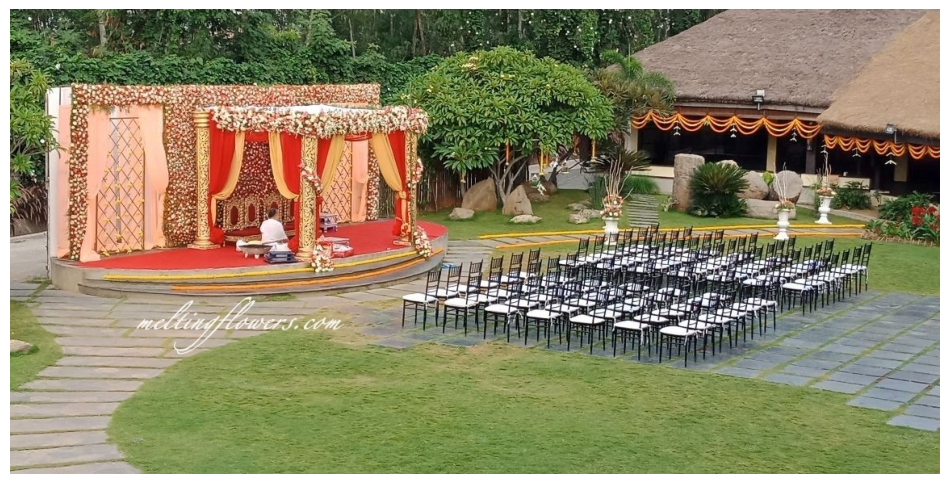

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import json
import numpy as np
import requests

def plot_fabric_1000_scale(image_path, json_response):
    # 1. Load Image
    try:
        im = Image.open(requests.get(image_path, stream=True).raw)
    except FileNotFoundError:
        print("Image not found.")
        return

    img_width, img_height = im.size

    # 2. Parse JSON
    if isinstance(json_response, str):
        # Clean specific markdown wrappers if present
        json_clean = json_response.replace("```json", "").replace("```", "").strip()
        data = json.loads(json_clean)
    else:
        data = json_response

    # 3. Setup Plot
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im)

    # 4. Draw Boxes
    for item in data.get("elements", []):
        if "box_2d" in item:
            # EXTRACT 1000-SCALE COORDS
            # Format: [ymin, xmin, ymax, xmax]
            ymin_1k, xmin_1k, ymax_1k, xmax_1k = item["box_2d"]

            # CONVERT TO PIXELS
            # (val / 1000) * total_dimension
            x1 = (xmin_1k / 1000) * img_width
            y1 = (ymin_1k / 1000) * img_height
            x2 = (xmax_1k / 1000) * img_width
            y2 = (ymax_1k / 1000) * img_height

            # Calculate width/height for matplotlib
            width = x2 - x1
            height = y2 - y1

            # Draw Box
            rect = patches.Rectangle(
                (x1, y1), width, height,
                linewidth=2, edgecolor='#00FF00', facecolor='none' # Green for visibility
            )
            ax.add_patch(rect)

            # Add Label
            label_text = f"{item['label']}"
            plt.text(
                x1, y1 - 5, label_text,
                color='black', fontsize=9, weight='bold',
                bbox=dict(facecolor='#00FF00', alpha=0.8, edgecolor='none')
            )

    plt.axis('off')
    plt.show()

# Run the function
# Note: Ensure you have a real image file named "decor_setup.jpg" or change the path
image_url = "https://imageswedding.theweddingcompany.com/bh_prod_bucket/weddings/ideabook/DECORATION/065b816d-40ce-4078-8259-cb9b33e93ce5/B0A21FBA-501C-4FC8-B3CF-02D4C811FFD4.jpg"
plot_fabric_1000_scale(image_url, api_output)

In [ ]:
import requests
# Load the image
# data = json.loads(output)
img = Image.open(requests.get(image_url, stream=True).raw)

img.size

(1152, 576)

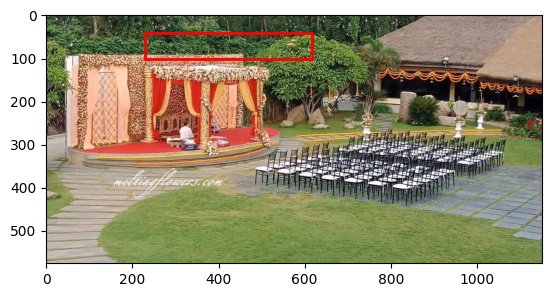

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Load your image to get dimensions
# img = Image.open('your_image.jpg') # Replace with your image source
img_w, img_h = img.size

# Example: Box in normalized 0-1000 format [xmin, ymin, xmax, ymax]
# This is common for OCR models like Tesseract or LayoutLM
norm_box = [198, 70, 536, 175]

# 1. Convert Normalized coordinates back to Pixels
# Formula: (Normalized_Value / 1000) * Image_Dimension
p_xmin = (norm_box[0] * img_w) / 1000
p_ymin = (norm_box[1] * img_h) / 1000
p_xmax = (norm_box[2] * img_w) / 1000
p_ymax = (norm_box[3] * img_h) / 1000

# 2. Calculate Width and Height for Matplotlib
p_width = p_xmax - p_xmin
p_height = p_ymax - p_ymin

# 3. Visualization
fig, ax = plt.subplots()
ax.imshow(img)

# Create a rectangle patch using the calculated pixel values
rect = patches.Rectangle(
    (p_xmin, p_ymin),
    p_width,
    p_height,
    linewidth=2,
    edgecolor='r',
    facecolor='none'
)

ax.add_patch(rect)
plt.show()

[198, 70, 338, 105]


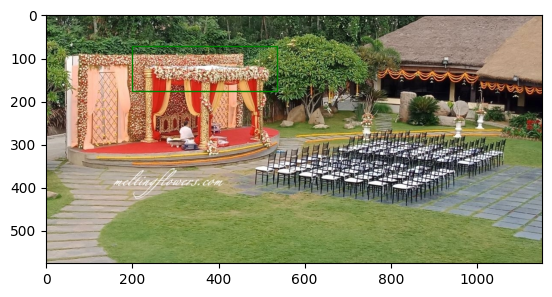

In [46]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import json

fig, ax = plt.subplots()
ax.imshow(img)

box = [198, 70, 536, 175]
f_box = [box[0], box[1], box[2]- box[0], box[3] - box[1]]
# f_box = [f_box[0]*1000//img.size[0], f_box[1]*1000//img.size[1], f_box[2]*1000//img.size[0], f_box[3]*1000//img.size[1]]
# f_box = [215, 203, 514, 442]
print(f_box)
# Loop through the boxes and draw themdd
# ymin, xmin, height, width = bbox
xmin, ymin, width, height = f_box
# Create a rectangle patch
rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='g', facecolor='none')
ax.add_patch(rect)

plt.show()

In [47]:
api_key='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'

🔍 Analyzing image...
📄 Raw JSON Response:
{
  "fabric_detected": true,
  "confidence_score": "98%",
  "elements": [
    {
      "description": "Red and gold Mandap drapes",
      "location": "wall",
      "coordinates": [
        0.205,
        203,
        0.442,
        532
      ],
      "reasoning": "The material is hanging freely from the Mandap frame, showing clear vertical ripples and gathered fabric nodes at the pillars. Meets the Hanging Rule (Rule D)."
    },
    {
      "description": "Peach/Light Orange side-backdrop drapes",
      "location": "wall",
      "coordinates": [
        0.068,
        198,
        0.175,
        535
      ],
      "reasoning": "Loose textile curtain with vertical folds and soft drapes over a metal lattice. Exhibits fluidity and texture consistent with fabric. Meets the Hanging Rule (Rule D)."
    },
    {
      "description": "Yellow floral swags/garlands on roofline",
      "location": "ceiling",
      "coordinates": [
        0.655,
        20

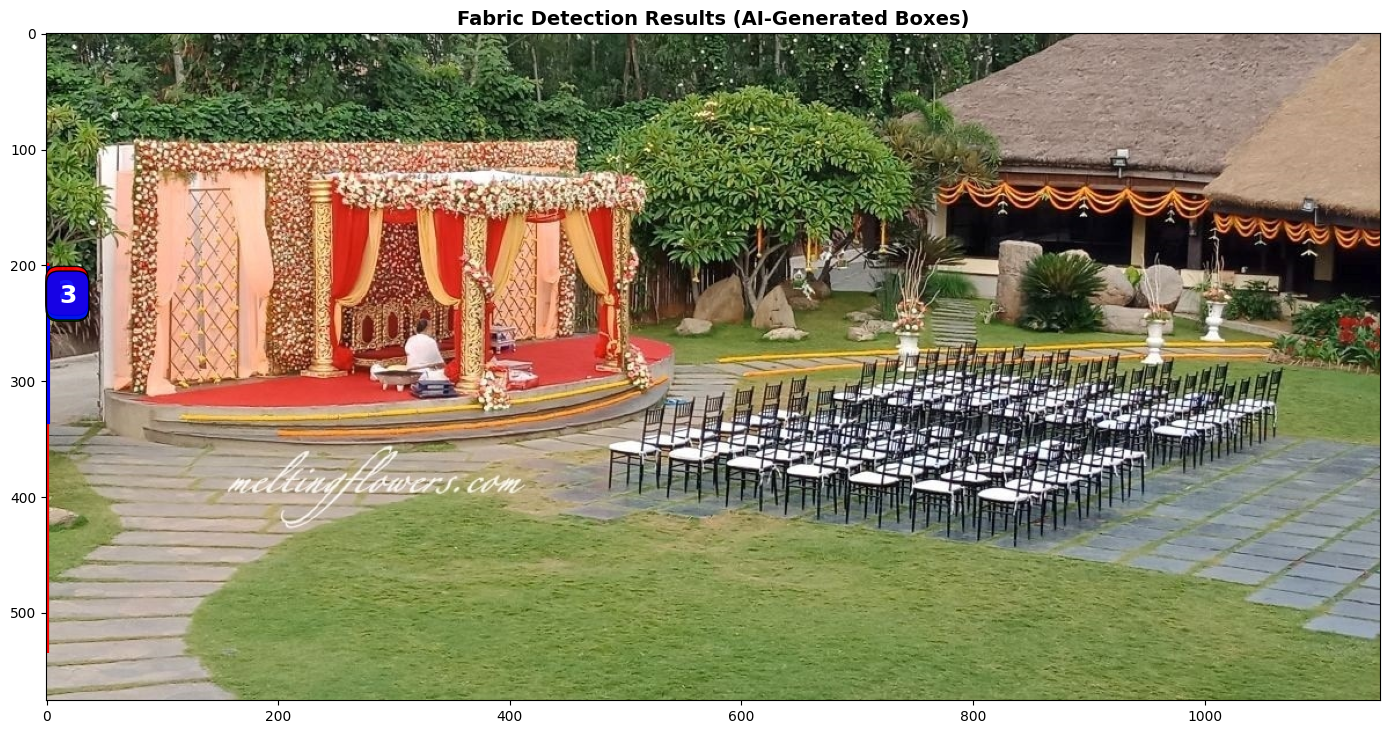

FABRIC DETECTION ANALYSIS REPORT

📊 DETECTION STATUS: ✅ FABRIC DETECTED
🎯 CONFIDENCE SCORE: 98%

🎨 DETECTED FABRIC ELEMENTS (3)
--------------------------------------------------------------------------------

[1] Red and gold Mandap drapes
    📍 Location: wall
    📐 Coordinates: [0.205, 203, 0.442, 532]
    💭 Reasoning: The material is hanging freely from the Mandap frame, showing clear vertical ripples and gathered fabric nodes at the pillars. Meets the Hanging Rule (Rule D).

[2] Peach/Light Orange side-backdrop drapes
    📍 Location: wall
    📐 Coordinates: [0.068, 198, 0.175, 535]
    💭 Reasoning: Loose textile curtain with vertical folds and soft drapes over a metal lattice. Exhibits fluidity and texture consistent with fabric. Meets the Hanging Rule (Rule D).

[3] Yellow floral swags/garlands on roofline
    📍 Location: ceiling
    📐 Coordinates: [0.655, 202, 0.998, 335]
    💭 Reasoning: While they contain floral elements, they are arranged as flexible fabric-like swags (U-shape

In [ ]:
import json
import requests
from PIL import Image, ImageDraw, ImageFont
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Your existing prompt
fabric_detection_prompt = """
**System Role:**
You are a Senior Event Decor Estimator and Computer Vision Specialist. Your task is to analyze decor images and precisely identify elements that qualify as **"Fabric"** for pricing purposes.

**Objective:**
Analyze the provided image and identify specific areas or objects that meet the strict definition of "Fabric" based on visual physics (gravity/drape) and cost-logic rules.

**CRITICAL: COORDINATE SPECIFICATION**
For EACH fabric element, you MUST provide PRECISE bounding box coordinates:
- Format: [x1, y1, x2, y2] where (x1,y1) is TOP-LEFT corner and (x2,y2) is BOTTOM-RIGHT corner
- Use NORMALIZED coordinates between 0.0 and 1.0 (percentage of image width/height)
- Example: [0.1, 0.2, 0.4, 0.6] means box starts at 10% from left, 20% from top, ends at 40% from left, 60% from top
- The box should TIGHTLY fit around ONLY the fabric element, not surrounding areas
- Be extremely precise - verify your coordinates describe the exact fabric location

**1. VISUAL IDENTIFICATION PROTOCOL (The "Physics" Check)**
First, identify potential candidates by looking for these physical properties:
* **Fluidity:** Look for soft folds, ripples, deep creases, or "swags" (U-shapes). The object must clearly obey gravity in a non-rigid way.
* **Texture:** Look for the soft sheen of satin, the matte weave of linen, or transparency in nets/voiles.
* **Furniture Overlays:** Identify loose textiles draped over sofas, deewans, or chairs.

**2. EXCLUSION PROTOCOL (The "Material" Check)**
Discard any candidates that match these descriptions:
* **Rigid Surfaces:** If it is perfectly flat, stiff, or lacks ripples, it is Flex Print, PVC, or Wood. **IGNORE.**
* **Artificial Textures:** Artificial grass (bladed texture) or paper streamers (crisp edges). **IGNORE.**

**3. LOGIC & CLASSIFICATION RULES (The "Pricing" Check)**
Apply these final filters to your valid candidates:
* **Rule A: The Structural Rule (CRITICAL):**
    * Is the fabric tightly wrapped/stapled like a "skin" over a raised stage, step, or wooden backdrop?
    * **IF YES:** Classify as `Platform` or `Structure`. **Do NOT tag as Fabric.**
* **Rule B: The Floor Rule:**
    * Is the textile loose/running on flat ground? -> **Tag as Fabric.**
    * Is it fixed onto a raised platform? -> **Tag as Platform.**
* **Rule C: The Floral Overlap Rule:**
    * Does floral arrangement cover >70% of the surface? -> **Tag as Floral.**
    * Is the fabric clearly visible (>30% surface area)? -> **Tag as Fabric.**
* **Rule D: The Hanging Rule:**
    * Is the material hanging freely (ceiling drops, swags, tunnel drapes)? -> **ALWAYS Tag as Fabric.**

**4. OUTPUT FORMAT:**
You must output ONLY valid JSON. Do not include markdown formatting (like ```json).

{
  "fabric_detected": boolean,
  "confidence_score": "0-100%",
  "elements": [
    {
      "description": "Brief description of the item (e.g., White sheer ceiling drape)",
      "location": "ceiling | wall | floor | furniture",
      "coordinates": [x1, y1, x2, y2],
      "reasoning": "Why it qualifies based on the rules"
    }
  ],
  "excluded_elements": [
    {
      "description": "Brief description of item excluded",
      "rule_applied": "The Structural Rule | The Floral Overlap Rule | Material Check"
    }
  ]
}
"""

class FabricDetectionVisualizer:
    def __init__(self, api_key):
        self.api_key = api_key
        self.base_url = "https://openrouter.ai/api/v1"

    def analyze_image(self, image_url):
        """Call the API to analyze the image"""
        headers = {
            "Authorization": f"Bearer {self.api_key}",
            "Content-Type": "application/json"
        }

        payload = {
            "model": "google/gemini-3-flash-preview",
            "messages": [
                {"role": "system", "content": fabric_detection_prompt},
                {"role": "user", "content": [
                    {"type": "text", "text": "Analyze this decor image."},
                    {"type": "image_url", "image_url": {"url": image_url}}
                ]}
            ]
        }

        response = requests.post(
            f"{self.base_url}/chat/completions",
            headers=headers,
            json=payload
        )

        if response.status_code == 200:
            content = response.json()['choices'][0]['message']['content']
            # Clean up the response if it has markdown formatting
            content = content.replace('```json', '').replace('```', '').strip()
            return json.loads(content)
        else:
            raise Exception(f"API Error: {response.status_code} - {response.text}")

    def visualize_results(self, image_url, detection_result):
        """Visualize the detection results on the image"""
        # Download image
        response = requests.get(image_url)
        img = Image.open(BytesIO(response.content))
        img_width, img_height = img.size

        # Create figure with subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

        # Original image
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=14, fontweight='bold')
        ax1.axis('off')

        # Annotated image
        ax2.imshow(img)
        ax2.set_title('Fabric Detection Results', fontsize=14, fontweight='bold')
        ax2.axis('off')

        # Draw bounding boxes for detected fabric elements
        colors = ['#00ff00', '#0080ff', '#ff00ff', '#ffff00', '#ff8000', '#00ffff']
        if detection_result.get('fabric_detected') and detection_result.get('elements'):
            for idx, element in enumerate(detection_result['elements']):
                if 'coordinates' in element and element['coordinates']:
                    coords = element['coordinates']
                    x1, y1, x2, y2 = coords

                    # Check if coordinates are normalized (0-1 range)
                    if all(0 <= c <= 1 for c in coords):
                        # Convert normalized coordinates to pixel coordinates
                        x1 = x1 * img_width
                        y1 = y1 * img_height
                        x2 = x2 * img_width
                        y2 = y2 * img_height

                    # Ensure x2 > x1 and y2 > y1
                    width = abs(x2 - x1)
                    height = abs(y2 - y1)
                    x1 = min(x1, x2)
                    y1 = min(y1, y2)

                    # Create rectangle
                    rect = patches.Rectangle(
                        (x1, y1), width, height,
                        linewidth=4,
                        edgecolor=colors[idx % len(colors)],
                        facecolor='none'
                    )
                    ax2.add_patch(rect)

                    # Add label with background
                    ax2.text(x1 + 5, y1 + 20, f"{idx+1}",
                            bbox=dict(boxstyle='round,pad=0.5', facecolor=colors[idx % len(colors)], alpha=0.8),
                            fontsize=16, fontweight='bold', color='black')

        plt.tight_layout()
        plt.show()

    def print_detailed_report(self, detection_result):
        """Print a detailed text report of the detection results"""
        print("\n" + "="*80)

    def visualize_with_interactive_adjustment(self, image_url, detection_result):
        """Interactive visualization that allows manual adjustment"""
        import matplotlib.pyplot as plt
        from matplotlib.patches import Rectangle

        response = requests.get(image_url)
        img = Image.open(BytesIO(response.content))
        img_width, img_height = img.size

        fig, ax = plt.subplots(1, 1, figsize=(14, 10))
        ax.imshow(img)
        ax.set_title('Fabric Detection Results (AI-Generated Boxes)', fontsize=14, fontweight='bold')

        colors = ['#00ff00', '#ff0000', '#0000ff', '#ffff00', '#ff00ff', '#00ffff']

        print("\n" + "="*80)
        print("BOUNDING BOX ANALYSIS")
        print("="*80)

        if detection_result.get('fabric_detected') and detection_result.get('elements'):
            for idx, element in enumerate(detection_result['elements']):
                if 'coordinates' in element and element['coordinates']:
                    coords = element['coordinates']
                    x1, y1, x2, y2 = coords

                    # Convert if normalized
                    if all(0 <= c <= 1 for c in coords):
                        x1_px, y1_px = x1 * img_width, y1 * img_height
                        x2_px, y2_px = x2 * img_width, y2 * img_height
                    else:
                        x1_px, y1_px, x2_px, y2_px = x1, y1, x2, y2

                    width = abs(x2_px - x1_px)
                    height = abs(y2_px - y1_px)
                    x1_px = min(x1_px, x2_px)
                    y1_px = min(y1_px, y2_px)

                    print(f"\n[{idx+1}] {element.get('description', 'Unknown')}")
                    print(f"    Normalized: [{x1:.3f}, {y1:.3f}, {x2:.3f}, {y2:.3f}]")
                    print(f"    Pixels: [{int(x1_px)}, {int(y1_px)}, {int(x2_px)}, {int(y2_px)}]")
                    print(f"    Size: {int(width)}x{int(height)}px")

                    rect = Rectangle(
                        (x1_px, y1_px), width, height,
                        linewidth=3,
                        edgecolor=colors[idx % len(colors)],
                        facecolor='none'
                    )
                    ax.add_patch(rect)

                    ax.text(x1_px + 10, y1_px + 30, f"{idx+1}",
                            bbox=dict(boxstyle='round,pad=0.5', facecolor=colors[idx % len(colors)], alpha=0.9),
                            fontsize=18, fontweight='bold', color='white')

        print("\n" + "="*80)
        plt.tight_layout()
        plt.show()
        print("FABRIC DETECTION ANALYSIS REPORT")
        print("="*80)

        print(f"\n📊 DETECTION STATUS: {'✅ FABRIC DETECTED' if detection_result.get('fabric_detected') else '❌ NO FABRIC DETECTED'}")
        print(f"🎯 CONFIDENCE SCORE: {detection_result.get('confidence_score', 'N/A')}")

        if detection_result.get('elements'):
            print(f"\n🎨 DETECTED FABRIC ELEMENTS ({len(detection_result['elements'])})")
            print("-" * 80)
            for idx, element in enumerate(detection_result['elements'], 1):
                print(f"\n[{idx}] {element.get('description', 'Unknown')}")
                print(f"    📍 Location: {element.get('location', 'N/A')}")
                if 'coordinates' in element:
                    print(f"    📐 Coordinates: {element.get('coordinates')}")
                print(f"    💭 Reasoning: {element.get('reasoning', 'N/A')}")

        if detection_result.get('excluded_elements'):
            print(f"\n🚫 EXCLUDED ELEMENTS ({len(detection_result['excluded_elements'])})")
            print("-" * 80)
            for idx, element in enumerate(detection_result['excluded_elements'], 1):
                print(f"\n[{idx}] {element.get('description', 'Unknown')}")
                print(f"    📋 Rule Applied: {element.get('rule_applied', 'N/A')}")

        print("\n" + "="*80)

# Usage Example
if __name__ == "__main__":
    # Initialize visualizer
    API_KEY = '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'
    visualizer = FabricDetectionVisualizer(API_KEY)

    # Test image URL
    image_url = "https://imageswedding.theweddingcompany.com/bh_prod_bucket/weddings/ideabook/DECORATION/065b816d-40ce-4078-8259-cb9b33e93ce5/B0A21FBA-501C-4FC8-B3CF-02D4C811FFD4.jpg"

    try:
        print("🔍 Analyzing image...")
        result = visualizer.analyze_image(image_url)

        print("📄 Raw JSON Response:")
        print(json.dumps(result, indent=2))

        # Print detailed report
        visualizer.print_detailed_report(result)

        # Visualize with coordinate details
        print("\n🖼️  Generating visualization with coordinate analysis...")
        visualizer.visualize_with_interactive_adjustment(image_url, result)

    except Exception as e:
        print(f"❌ Error: {str(e)}")

In [ ]:
#data making

In [69]:
import json

with open('/Users/betterhalf/Desktop/betterhalf_/pricing_prediction/DATA/train_coco.json', 'r') as f:
    data = json.load(f)

In [71]:
data['images'][0]

{'id': 1,
 'file_name': '47110090-0A62B9FC-046F-4B42-B764-D3584A199440.jpeg',
 'width': 612,
 'height': 612}

In [76]:
final_data = []
for i in data['images']:
    dic = {}
    id = i['id']
    file_name = i['file_name']
    width = i['width']
    height = i['height']
    dic[file_name] = []
    for j in data['annotations']:
        if j['image_id'] == id:
            bbox = j['bbox']
            xmin, ymin, box_width, box_height = bbox
            xmax = xmin + box_width
            ymax = ymin + box_height
            normalized_bbox = [xmin*1000/width, ymin*1000/height, xmax*1000/width, ymax*1000/height]
            dic[file_name].append({'box_2d': normalized_bbox, 'label': 'Fabric'})
    final_data.append(dic)

len(final_data)


149

# New